IMPORTING NECESSARY PACKAGES

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


DATA LOADING

In [ ]:
data = pd.read_csv('/content/sign_mnist_train.csv')
print('Dataframe Shape:', data.shape)

Dataframe Shape: (27455, 785)


In [ ]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
x = data.iloc[:, 1:].values
print("Number of images:", x.shape[0])
print("Number of pixels in each image:", x.shape[1])

Number of images: 27455
Number of pixels in each image: 784


In [ ]:
x

array([[107, 118, 127, ..., 204, 203, 202],
       [155, 157, 156, ..., 103, 135, 149],
       [187, 188, 188, ..., 195, 194, 195],
       ...,
       [174, 174, 174, ..., 202, 200, 200],
       [177, 181, 184, ...,  64,  87,  93],
       [179, 180, 180, ..., 205, 209, 215]])

In [ ]:
y = data.iloc[:,0].values.flatten()
print(y)
print(y.shape)

[ 3  6  2 ... 18 17 23]
(27455,)


In [ ]:
def next_batch(batch_size, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[: batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [ ]:
def display_images(data):
    x, y = data
    fig, axes = plt.subplots(4, 4)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i].reshape(28, 28), cmap = 'binary')
        ax.set_xlabel(chr(y[i] + 65))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

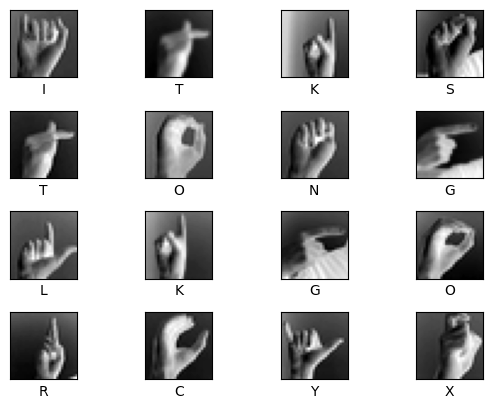

In [ ]:
display_images(next_batch(16, x, y))

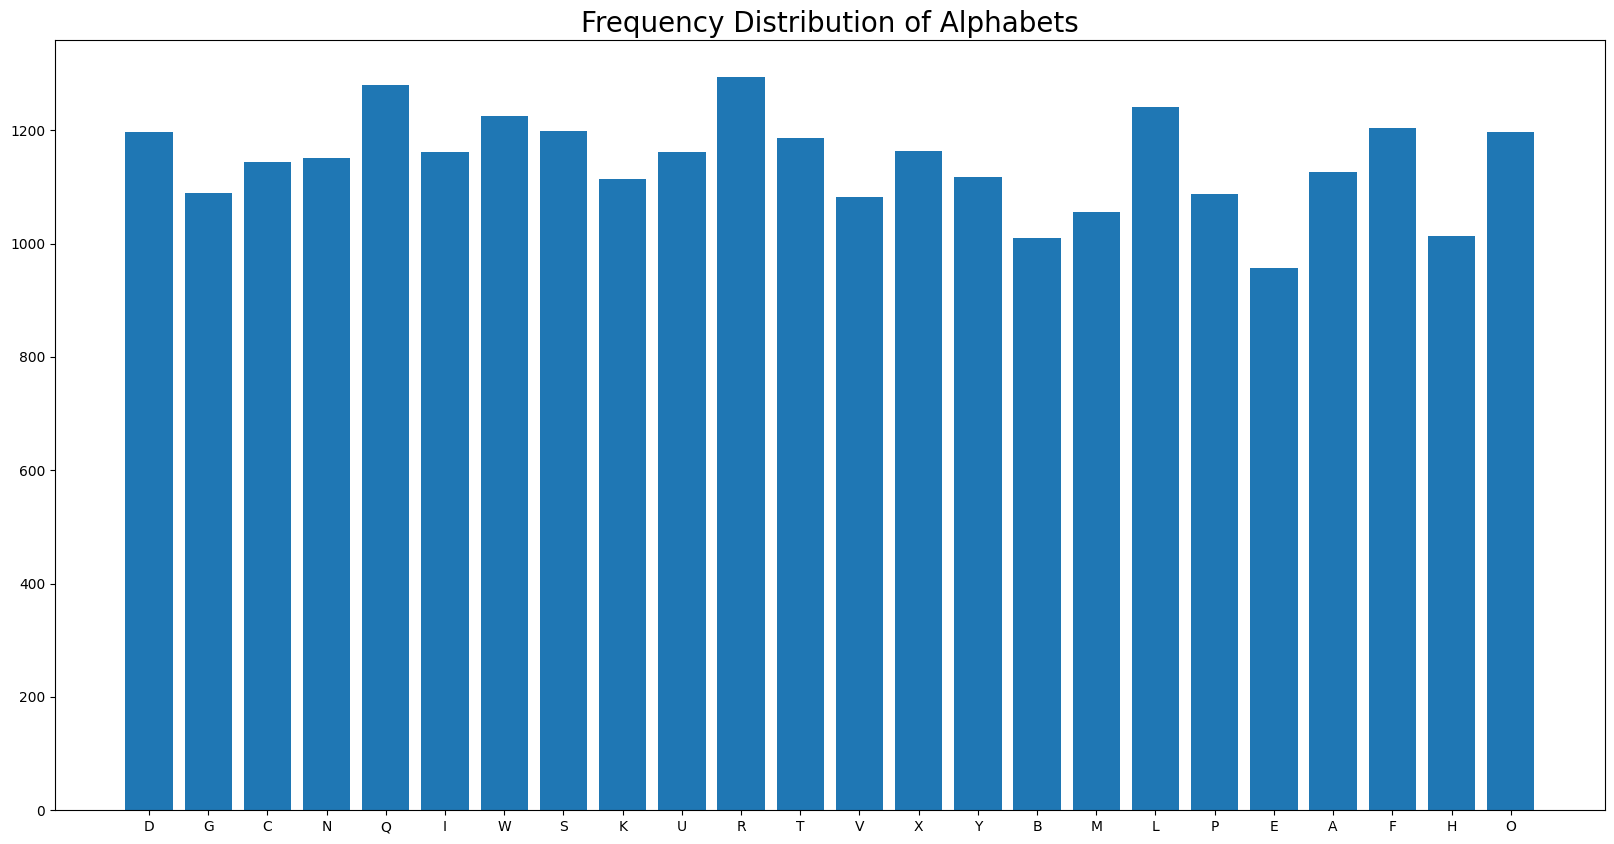

In [ ]:
z = dict(Counter(list(y)))
labels = z.keys()
frequencies = [z[i] for i in labels]
labels = [chr(i + 65) for i in z.keys()]

plt.figure(figsize = (20, 10))
plt.bar(labels, frequencies)
plt.title('Frequency Distribution of Alphabets', fontsize = 20)
plt.show()

In [ ]:
def one_hot_encode(y):
    return np.eye(25)[y]
y_encoded = one_hot_encode(y)
print('Shape of y after encoding:', y_encoded.shape)
print(y_encoded)

Shape of y after encoding: (27455, 25)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [ ]:
learning_rate = 0.001
epochs = 1500
batch_size = 128
display_step = 100

In [ ]:
n_input = 784
n_classes = 25
dropout = 0.75

In [ ]:
X = tf.placeholder(tf.float32, shape = [None, n_input]) # Placeholder for Feature Matrix
Y = tf.placeholder(tf.float32, shape = [None, n_classes]) # Placeholder for Labels
keep_prob = tf.placeholder(tf.float32)

In [ ]:
weights = {
    'w1' : tf.Variable(tf.random_normal([5, 5, 1, 32])),
    'w2' : tf.Variable(tf.random_normal([5, 5, 32, 64])),
    'w3' : tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    'w4' : tf.Variable(tf.random_normal([1024, n_classes]))
}

In [ ]:
biases = {
    'b1' : tf.Variable(tf.random_normal([32])),
    'b2' : tf.Variable(tf.random_normal([64])),
    'b3' : tf.Variable(tf.random_normal([1024])),
    'b4' : tf.Variable(tf.random_normal([n_classes]))
}

In [ ]:
def conv2d(x, W, b, strides = 1):
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [ ]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

In [ ]:
def neural_network(x, weight, bias, dropout):
    x = tf.reshape(x, shape = [-1, 28, 28, 1])

    conv1 = conv2d(x, weight['w1'], bias['b1'])
    conv1 = maxpool2d(conv1)

    conv2 = conv2d(conv1, weight['w2'], bias['b2'])
    conv2 = maxpool2d(conv2)
    fc = tf.reshape(conv2, [-1, weights['w3'].get_shape().as_list()[0]])
    fc = tf.add(tf.matmul(fc, weight['w3']), bias['b3'])
    fc = tf.nn.relu(fc)

    fc = tf.nn.dropout(fc, dropout)

    out = tf.add(tf.matmul(fc, weight['w4']), bias['b4'])
    return out

In [ ]:
logits = neural_network(X, weights, biases, keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
loss_op = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = Y)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

In [ ]:
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
print('Training on the whole dataset')
with tf.Session() as sess:
    sess.run(init) # Running Initializer
    cost_hist, acc_hist = [], []
    for epoch in range(1, epochs + 1):
        _x, _y = next_batch(batch_size, x, y_encoded)
        # Running Optimizer
        sess.run(train_op,
                 feed_dict = {
                     X : _x,
                     Y : _y,
                     keep_prob : dropout
                 })
        if epoch % display_step == 0:
            loss, acc = sess.run([loss_op, accuracy],
                                 feed_dict = {
                                     X : _x,
                                     Y : _y,
                                     keep_prob : 1.0
                                 })
            loss = sum(loss)
            cost_hist.append(loss)
            acc_hist.append(acc)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy: ' + str(acc * 100) + ' %')
            accurracy = str(acc * 100)
    print('Accuracy after training on whole dataset Data: ' + str(sess.run(accuracy,
                                                       feed_dict = {
                                                           X : x,
                                                           Y : y_encoded,
                                                           keep_prob : 1.0
                                                       }) * 100) + ' %')
    W = sess.run(weights)
    B = sess.run(biases)

Training on the whole dataset
Epoch 100, Cost: 158590907.625, Accuracy: 33.59375 %
Epoch 200, Cost: 44809739.4375, Accuracy: 64.0625 %
Epoch 300, Cost: 13671536.125, Accuracy: 78.90625 %
Epoch 400, Cost: 8642648.4375, Accuracy: 80.46875 %
Epoch 500, Cost: 3406933.375, Accuracy: 88.28125 %
Epoch 600, Cost: 851139.59375, Accuracy: 93.75 %
Epoch 700, Cost: 726243.75, Accuracy: 96.875 %
Epoch 800, Cost: 632140.65625, Accuracy: 96.09375 %
Epoch 900, Cost: 982651.375, Accuracy: 96.875 %
Epoch 1000, Cost: 76089.8125, Accuracy: 99.21875 %
Epoch 1100, Cost: 68375.0, Accuracy: 99.21875 %
Epoch 1200, Cost: 590928.5, Accuracy: 98.4375 %
Epoch 1300, Cost: 0.0, Accuracy: 100.0 %
Epoch 1400, Cost: 128353.625, Accuracy: 99.21875 %
Epoch 1500, Cost: 85661.875, Accuracy: 99.21875 %
Accuracy after training on whole dataset Data: 99.50100183486938 %


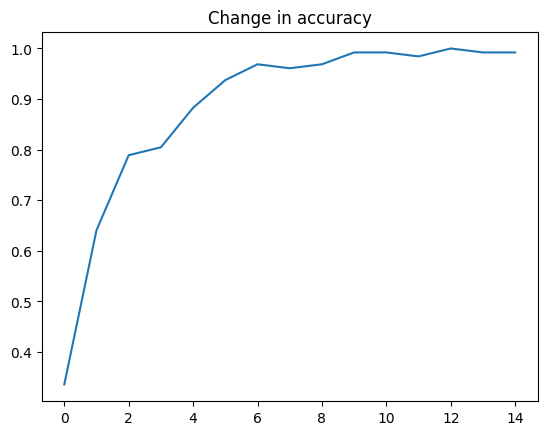

In [ ]:
plt.plot(list(range(len(acc_hist))), acc_hist)
plt.title("Change in accuracy")
plt.show()

In [ ]:
data_test = pd.read_csv('/content/sign_mnist_test.csv')
print(data_test.shape)

(7172, 785)


In [ ]:
data_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [ ]:
x_test = data_test.iloc[:, 1:].values
y_test = data_test.iloc[:,0].values.flatten()
y_test_encode = one_hot_encode(y_test)
print(x_test.shape)
print(y_test_encode.shape)

(7172, 784)
(7172, 25)


In [ ]:
X = tf.placeholder(tf.float32, shape = [None, n_input])
Y = tf.placeholder(tf.float32, shape = [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

In [ ]:
y_pred = neural_network(X, W, B, 1.0)

In [ ]:
def get_prediction(img):
    with tf.Session() as sess:
        pred = sess.run(y_pred, feed_dict = { X : img, keep_prob : 1.0 })
    img = img.reshape(28, 28)
    pred = list(pred.flatten())
    pred = chr(pred.index(max(pred)) + 65)
    return (img, pred)

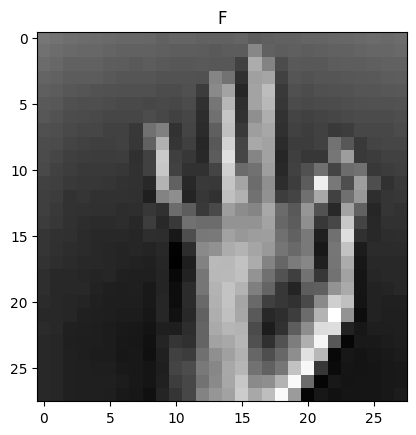

In [ ]:
image_flat = x_test[1].reshape(1, 784)

image, pred = get_prediction(image_flat)
plt.imshow(image.reshape(28, 28), cmap='binary')
plt.title(pred)
plt.show()

In [ ]:
for key in W.keys():
    np.save(key, W[key])

In [ ]:
for key in B.keys():
    np.save(key, B[key])

In [ ]:
#Area Under Curve Score
from sklearn.metrics import roc_auc_score

with tf.Session() as sess:
    y_pred = neural_network(X, W, B,1.0)

    # Calculate the predicted probabilities for all classes
    predicted_probs = sess.run(y_pred, feed_dict={X: x_test, keep_prob: 1.0})

    auc_scores = []
    for class_index in range(25):
        # Check if there is only one class instance, and skip if true
        if sum(y_test == class_index) <= 1:
            continue

        # Calculate AUC for each class
        y_true_class = (y_test == class_index)
        y_scores_class = predicted_probs[:, class_index]

        auc_score = roc_auc_score(y_true_class, y_scores_class)
        auc_scores.append(auc_score)

    if len(auc_scores) == 0:
        print("No class with enough instances to calculate AUC.")
    else:
        average_auc = sum(auc_scores) / len(auc_scores)
        print("Average AUC Score (Multi-class):", average_auc*100,"%")


Average AUC Score (Multi-class): 94.5347061195427 %


In [ ]:
from sklearn.metrics import accuracy_score

with tf.Session() as sess:
    y_pred = neural_network(X, W, B, 1.0)

    # Calculate the predicted class labels for the test data
    predicted_labels = sess.run(tf.argmax(y_pred, 1), feed_dict={X: x_test, keep_prob: 1.0})

    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, predicted_labels)

    print("Accuracy on Test Data:", accurracy,"%")


Accuracy on Test Data: 99.21875 %
